# 3. A Tour of Machine Learning Classifiers Using Scikit-Learn

## Choosing a classification algorithm

No single classifier works best across al possible scenarios (*NFL Theorem*). In practice, it is always recommended that you compare the performance of al least a handful of different learning algorithms to select the best model for the particular problem.

## First steps with scikit-learn - training a perceptron

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [2]:
print("Class labels:", np.unique(y))

Class labels: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

By default `train_test_split` shuffles the data before splitting

In [4]:
print("Labels counts in y:", np.bincount(y))
print("Labels count in train:", np.bincount(y_train))
print("Labels count in test:", np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels count in train: [35 35 35]
Labels count in test: [15 15 15]


In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Using the `fit` method, `StandardScaler` estimated the parameters, $\mu$ (sample mean) and $\sigma$ (standard deviation), for each feature dimension from training data. By calling `transform` method, we then standardized data using those estimated parameters, $\mu$ and $\sigma$.

Most algorithms in sklearn already support multiclass classification by default via the **one-versus-rest**(**OvR**) method.

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [7]:
y_pred = ppn.predict(X_test_std)
print("Misclassified examples: %d" % (y_test != y_pred).sum())

Misclassified examples: 1


In [8]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.978


In [9]:
print("Accuracy: %.3f" % ppn.score(X_test_std, y_test))

Accuracy: 0.978


**Overfitting:** The model captures patterns in the training data well but fails to generalize well to unseen data

In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(
    X, y, classifier, test_idx=None, resolution=0.02, xlabel="", ylabel="", title=""
):
    # setup marker generator and color map
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolors="black",
        )

    # highlight test examples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c="none",
            edgecolors="black",
            marker="o",
            alpha=1.0,
            linewidths=1,
            s=100,
            label="Test set",
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

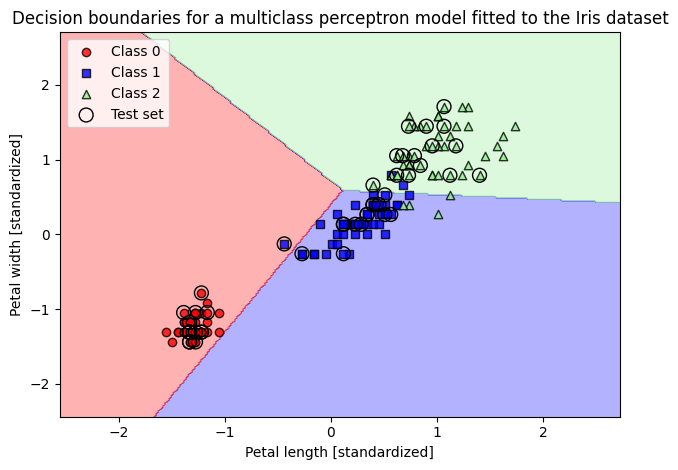

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X=X_combined_std,
    y=y_combined,
    classifier=ppn,
    test_idx=range(105, 150),
    xlabel="Petal length [standardized]",
    ylabel="Petal width [standardized]",
    title="Decision boundaries for a multiclass perceptron model fitted to the Iris dataset",
)

As we can see in the resulting plot, the three flower classes can't be perfectly separated by linear decision boundary. Perceptron algorithm never converges on datasets that aren't perfectly linear separable, which is why the use of perceptron algorithm is typically not recommended in practice.

## Logistic regression and conditional probabilities

Performs well on linearly separable classes. It is one of the most widely used algorithms for binary classification in industry. Logistic regression can be readily generalized to multiclass settings, which is known as **multinomial logistic regression**, or **softmax regression**. Another way to use logistic regression in multiclass settings is via OvR technique.

To explain mechanics behind **logistic regression** as a probabilistic model for binary classification, let's introduce the **odds**:
$$
\frac{p}{1-p}
$$
Where $p$ stands for the probability of the positive event (event we want to predict). For example if the positive event is $y=1$ and $x$ the features, we can define probability $p$ as $p:=(y=1|x)$, the conditional probability that a particular example belongs to a certain class 1 given its features, **x**.

We can further define **logit** function, which is simply the logarithm of the odds:
$$
\text{logit(p)} = \log\frac{p}{(1-p)}
$$

Remember that log is
$$
\log_{b}(b^{x}) = x
$$

In computer science, log refers to natural logarithm. Takes input in the range 0 to 1 and transforms them into values over the entire real-number range.

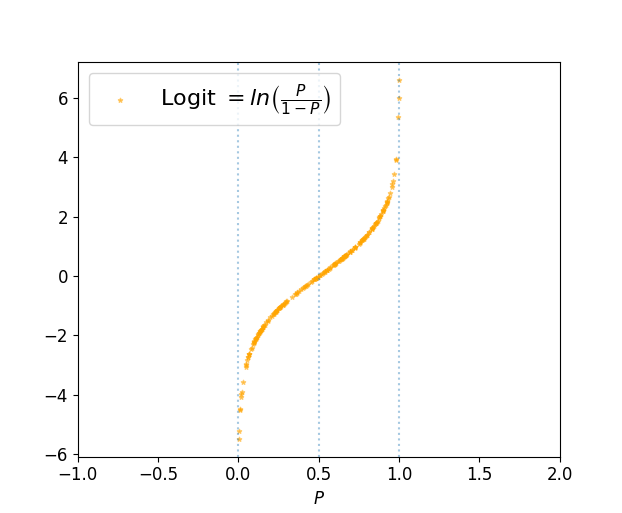


Under the logistic model, we assume that there is a linear relationship between weighted inputs (net inputs) and the log-odds:
$$
\text{logit}(p) = w_1x_1 + ... + w_mx_m + b = \sum_{i=j} w_jx_j + b = \mathbf{w^Tx} + b
$$

While the logit function maps the probability to a real-number range, we can consider the inverse of this function to map the real-number range back to a [0, 1] range for the probability $p$. This inverse is called the **logistic sigmoid function** or simply **sigmoid function** due to its characteristic S-shape:

Using $e^{ln(x)}=x$ property:
$$
\begin{align}
\text{logit(p)} &= \log(\frac{p}{1-p}) \\
x &= \log(\frac{p}{1-p})    \\
e^x &= e^{\log(\frac{p}{1-p})}  \\
e^x &= \frac{p}{1-p}    \\
e^x(1-p) &= p \\
e^x - e^x p &= p \\
e^x &= p + e^x p \\
e^x &= p (1 + e^x) \\
\frac{e^x}{1+e^x} &= p      \\
\frac{1}{e^{-x}+1} &= p


\end{align}
$$

The sigmoid function is:
$$
\sigma (z) = \frac{1}{1 + e^{-z}}
$$

where:
$$
z = \mathbf{w^Tx} + b
$$

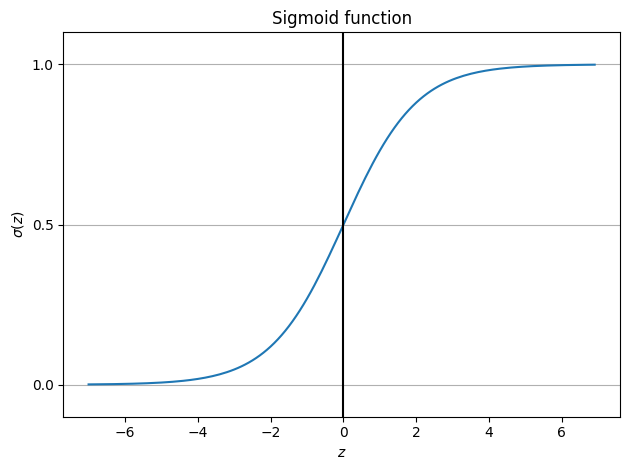

In [12]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)

plt.axvline(0.0, color="black")
plt.ylim(-0.1, 1.1)
plt.yticks([0.0, 0.5, 1.0])
plt.grid(True, axis="y")

plt.xlabel("$z$")
plt.ylabel("$\sigma(z)$")
plt.title("Sigmoid function")

plt.tight_layout()
plt.show()

In Adaline, we used the identity function, $\sigma(z) = z$, as the activation function. In logistic regression, this activation function simply becomes the sigmoid.

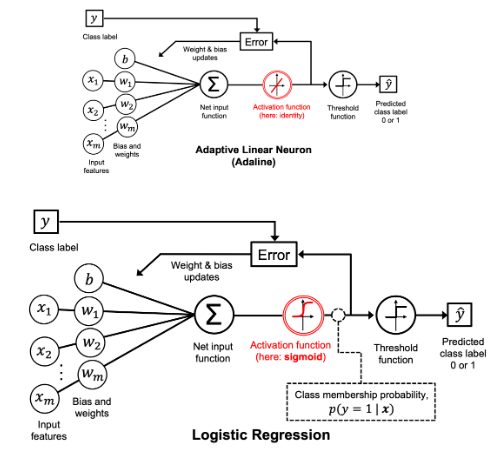

Logistic regression compared to Adaline

The output of the sigmoid function is then interpreted as the probability of a particular example belonging to class 1, $\sigma(z) = p(y = 1|\mathbf{x;w},b)$, given its features, $x$, and parameterized by weights and bias, $w$ and $b$
Where *;* separates input from parameters.

Note that:
$$
p(y = 0|\mathbf{x;w},b) = 1 - p(y = 1|\mathbf{x;w},b)
$$

The predicted probability can be simply be converted into binary outcome via threshold function:

$$
ŷ = 
\begin{cases}
1 & \text{if } \sigma (z) \geq 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

equivalent to:

$$
ŷ = 
\begin{cases}
1 & \text{if } z \geq 0.0 \\
0 & \text{otherwise}
\end{cases}
$$

Many applications are not only interested in the predicted class labels, but the estimation of the class-membership probability (weather forecasting, medicine...)

## Learning the model weights via the logistic loss function

Mean square loss, "*the loss function of w and b given x*":
$$
L(\mathbf{w}, b| \mathbf{x}) = \frac{1}{n}\sum_i^{n}{(\sigma(z^{(i)}) - y^{(i)})^2}
$$

We minimized this function in order to learn the parameters for our Adaline classification model. 

For logistic regression loss function we need to define likelihood, $\mathcal{L}$, that we want to maximize, assuming that the individual examples in our dataset are independent of one another and identically distributed:
* **Independence:** Each data point ($x_i$) is assumed to be independent of the others. The presence or absence of one data point does not affect the probability of another data point.
* **Identically distributed:** All data points come from the same probability distribution.

Given the binary classification problem with class labels 0 and 1, we can think of the label 1 as a Bernoulli variable. For a single data point, we can write this probability as $P(Y = 1 | X = x^{(i)}) = \sigma(z^{(i)})$ and $P(Y = 0 | X = x^{(i)}) = 1 - \sigma(z^{(i)})$

Putting these two expressions together, we get the probability mass function of the Bernoulli variable:

$$
p(y^{(i)} | x^{(i)} ) = (\sigma(z^{(i)}))^{y^{(i)}}(1-\sigma(z^{(i)}))^{1-y^{(i)}}
$$

We can write the likelihood of the training labels given the assumption that all training examples are independent, using the multiplication rule to compute the probability that all events occur:

$$
\mathcal{L}(\mathbf{w}, b| \mathbf{x}) = p(y|\mathbf{x;w},b) = \prod_{i=1}^{n}p(y|\mathbf{x;w},b) = \prod_{i=1}^{n}(\sigma(z^{(i)}))^{y^{(i)}}(1-\sigma(z^{(i)}))^{1-y^{(i)}}
$$

In practice, it is easier to maximize the (natural) log of this equation, which is called the **log-likelihood** function:

Using the logarithm properties 
$$
\log(a \cdot b) = \log(a) + \log(b)
$$
$$
\log(a^b) = b \log(a) 
$$

The **log-likelihood** function:
$$
\begin{align}
\log \mathcal{L}(\mathbf{w}, b| \mathbf{x}) &= \log \prod_{i=1}^{n}(\sigma(z^{(i)})^{y^{(i)}})(1-\sigma(z^{(i)}))^{1-y^{(i)}} \\
&= \sum_{i=1}^{n} \log [(\sigma(z^{(i)})^{y^{(i)}})(1-\sigma(z^{(i)}))^{1-y^{(i)}}] \\
&= \sum_{i=1}^{n} [\log (\sigma(z^{(i)})^{y^{(i)}}) + \log ((1-\sigma(z^{(i)}))^{1-y^{(i)}})] \\
&= \sum_{i=1}^{n} [y^{(i)} \log (\sigma(z^{(i)})) + (1-y^{(i)}) \log (1-\sigma(z^{(i)}))]
\end{align}
$$


So
$$
l(\mathbf{w}, b| \mathbf{x}) = \log \mathcal{L}(\mathbf{w}, b| \mathbf{x}) = \sum_{i=1}^{n}[y^{(i)}\log(\sigma(z^{(i)})) + (1-y^{(i)}) \log (1-\sigma(z^{(i)}))]
$$

Applying the log function reduces the potential for numerical underflow, which can occur if the likelihoods are very small. Secondly, we can convert the product of factors into a summation of factors, which makes it easier to obtain the derivative of this function via the addition trick.

The log-likelihood function $\log \mathcal{L}(\mathbf{w}, b| \mathbf{x})$ tells us how likely the observed data is given a specific set of parameters, so we want to find the parameter values that best explain the data. We maximize the likelihood to find the parameters that make the data as likely as possible. Nonetheless, we want to minimize using gradient descent:

$$
L(\mathbf{w}, b) = \sum_{i=1}^{n}[-y^{(i)}\log(\sigma(z^{(i)})) - (1-y^{(i)}) \log (1-\sigma(z^{(i)}))]
$$

For 1 single training example:
$$
L(\sigma(z), y; \mathbf{w}, b) = -y\log(\sigma(z)) - (1-y) \log (1-\sigma(z))
$$

We can see that the first term becomes zero if $y=0$, and the second term becomes zero if $y=1$

$$
L(\sigma(z), y; \mathbf{w}, b) = 
\begin{cases}
-\log (1-\sigma(z)) & \text{if } y=0 \\
-\log(\sigma(z)) & \text{if } y=1
\end{cases}
$$


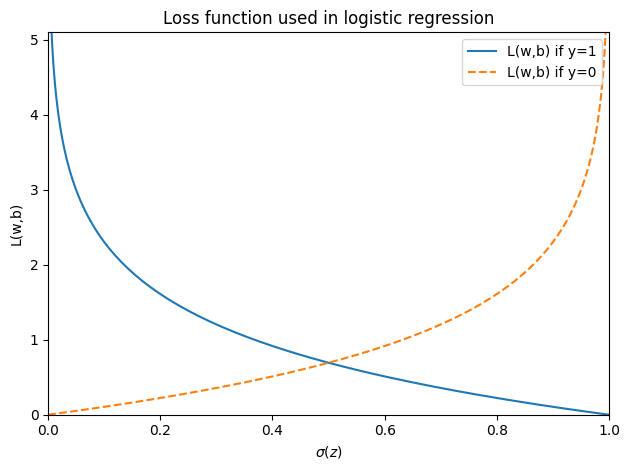

In [13]:
def loss_1(z):
    return -np.log(sigmoid(z))


def loss_0(z):
    return -np.log(1 - sigmoid(z))


z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

plt.plot(sigma_z, loss_1(z), label="L(w,b) if y=1")
plt.plot(sigma_z, loss_0(z), linestyle="--", label="L(w,b) if y=0")

plt.title("Loss function used in logistic regression")
plt.xlabel("$\sigma(z)$")
plt.ylabel("L(w,b)")

plt.xlim([0, 1])
plt.ylim([0.0, 5.1])

plt.legend(loc="best")
plt.tight_layout()
plt.show()

The resulting plot shows the sigmoid activation on the $x$ axis in the range 0 to 1 (the inputs to the sigmoid function were $z$ values in the range -10 to 10) and the associated logistic loss on the $y$ axis. We can see that the loss approaches 0 (continuous line) if we correctly predict that an example belongs to class 1. Similarly, we can see on the $y$ axis that the loss also approaches to 0 if we correctly predict y=0 (dashed line). If the prediction is wrong, the loss goes toward infinity (we penalize wrong predictions with an increasingly larger loss).

## Converting an Adaline implementation into an algorithm for logistic regression

$$
L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} [-y^{(i)} \log(\sigma (z^{(i)})) - (1 - y^{(i)}) \log(1 - \sigma (z^{(i)}))]
$$

In [14]:
class LogisticRegressionGD:
    """
    Gradient descent-based logistic regression classifier

    Parameters
    ----------
    lr : float
        Learning rate (between 0.0 and 1.0)
    epochs : int
        Passes over the training dataset
    random_state : int
        Random number generator seed for random weight initialization


    Attributes
    -----------
    w_ : 1d-array
        Weights after training
    b_ : Scalar
        Bias after fitting
    losses_ : list
        Log loss function values in each epoch
    """

    def __init__(self, lr=0.01, epochs=50, random_state=42):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit training data

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors
        y : array-like
            Labels

        Returns
        -------
        self : Instance of LogisticRegressionGD
        """

        # random initialization
        rgen = np.random.RandomState(seed=self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.0)
        self.losses_ = []

        for _ in range(self.epochs):
            output = self.activation(self.net_input(X))
            errors = y - output
            self.w_ += 2.0 * self.lr * X.T.dot(errors) / X.shape[0]
            self.b_ += 2.0 * self.lr * errors.mean()
            loss = -y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))
            loss /= X.shape[0]
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute the logistic sigmoid activation"""
        return 1.0 / (
            1.0 + np.exp(-np.clip(z, -250, 250))
        )  # clipped to prevent overflow

    def predict(self, X):
        """Return the class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

When we fit a logistic regression model we have to keep in mind that it only works for binary classification tasks.

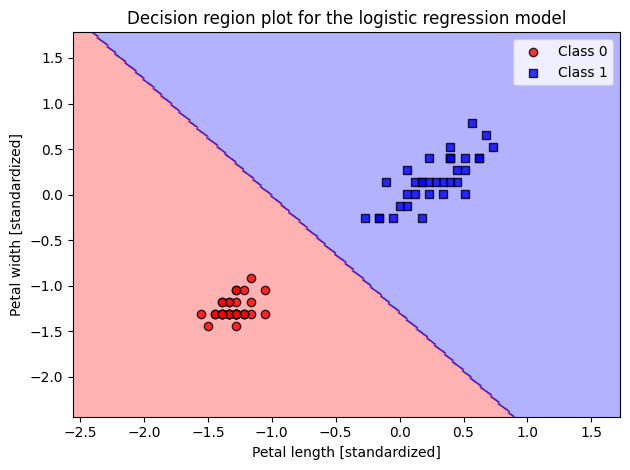

In [15]:
# Considering only class 0 and 1
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(lr=0.3, epochs=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(
    X_train_01_subset,
    y_train_01_subset,
    classifier=lrgd,
    xlabel="Petal length [standardized]",
    ylabel="Petal width [standardized]",
    title="Decision region plot for the logistic regression model",
)

**The gradient learning algorithm for logistic regression**
Weight and bias update rules from `LogisticRegressionGD` in the previous code with `AdalineGD` from *Chapter 2* remained unchanged. Using calculus, we can show that the parameter updates via GD are indeed similar.

<span style="color:red">Remember log notation is natural logarithm.</span> 

$$
L = [-y\log(\sigma(z))-(1-y)\log(1-\sigma(z))]
$$

We want $\frac{\partial L}{\partial w_j}$

So applying the chain rule
$$
\frac{\partial L}{\partial w_j} = \frac{\partial L}{\partial a} \frac{da}{dz} \frac{\partial z}{\partial w_j} 
$$

where $a=\sigma(z)$

$$
\boxed{
    \begin{align}
    \frac{\partial L}{\partial a} &= \frac{\partial}{\partial a} [-y\log(a)-(1-y)\log(1-a)] \\
    &= -y \frac{1}{a} - (1-y)\frac{1}{1-a}(-1) \\
    &= -\frac{y}{a} + \frac{1-y}{1-a} \\
    &= -\frac{y(1-a)}{a(1-a)} + \frac{a(1-y)}{a(1-a)} \\
    &= \frac{-y+ya + a -ya}{a (1-a)} \\
    &= \frac{a-y}{a(1-a)}
\end{align}
}
$$

$$
\boxed{
    \begin{align}
    \frac{da}{dz} &= \frac{d}{dz} \frac{1}{1 + e^{-z}} \\
    &= \frac{d}{dz} (1 + e^{-z})^{-1} \\
    &= (-1)(1 + e^{-z})^{-2}((-1)e^{-z}) \\
    &= \frac{-1}{(1 + e^{-z})^{2}} (-e^{-z}) \\
    &= \frac{e^{-z}}{(1 + e^{-z})^{2}} \\
    \end{align}
}
$$

as $a=\sigma(z)=\frac{1}{1 + e^{-z}} $ and $1-a=\frac{e^{-z}}{1+e^-{z}}$

$$
\boxed{
    \begin{align}
    \frac{da}{dz} = a(1-a)\\
    \end{align}
}
$$

$$
\boxed{
    \begin{align}
    \frac{\partial z}{\partial w_j} &= \frac{\partial}{\partial w_j} w_jx_j = x_j
    \end{align}
}

$$

The figure below summarizes how we can calculate the partial derivative of the log-likelihood function with respect to the *j*th weight:

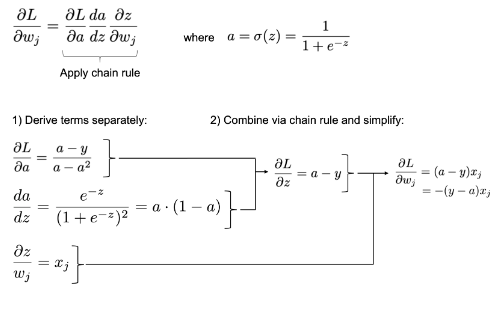

Hence, we flip $\frac{\partial{L}}{w_j} = - (y-a)x_j$ and update the *j*th weight as follows, including the learning rate $\eta$.
$$
w_j:= w_j + \eta(y-a)x_j
$$
While the partial derivative of the loss function with respect to the bias unit is not shown, bias derivation follows the same overall concept using the chain rule, resulting:
$$
b:= b + \eta(y-a)
$$

**Both the weight and bias unit updates are equal to the ones for Adaline in *Chapter 2***

## Training a logistic regression model with scikit-learn